Training for alpha = 1.00E-10
	 Training with 1500 minibatches, dataset size is 1500000
	 Accuracy for alpha 1.0E-10 : 0.770
	 Computing ROC curve ...
Training for alpha = 7.94E-10
	 Training with 1500 minibatches, dataset size is 1500000
	 Accuracy for alpha 7.9E-10 : 0.770
	 Computing ROC curve ...
Training for alpha = 6.31E-09
	 Training with 1500 minibatches, dataset size is 1500000
	 Accuracy for alpha 6.3E-09 : 0.770
	 Computing ROC curve ...
Training for alpha = 5.01E-08
	 Training with 1500 minibatches, dataset size is 1500000
	 Accuracy for alpha 5.0E-08 : 0.770
	 Computing ROC curve ...
Training for alpha = 3.98E-07
	 Training with 1500 minibatches, dataset size is 1500000
	 Accuracy for alpha 4.0E-07 : 0.770
	 Computing ROC curve ...
Training for alpha = 3.16E-06
	 Training with 1500 minibatches, dataset size is 1500000
	 Accuracy for alpha 3.2E-06 : 0.770
	 Computing ROC curve ...
Training for alpha = 2.51E-05
	 Training with 1500 minibatches, dataset size is 1500000
	 Accu

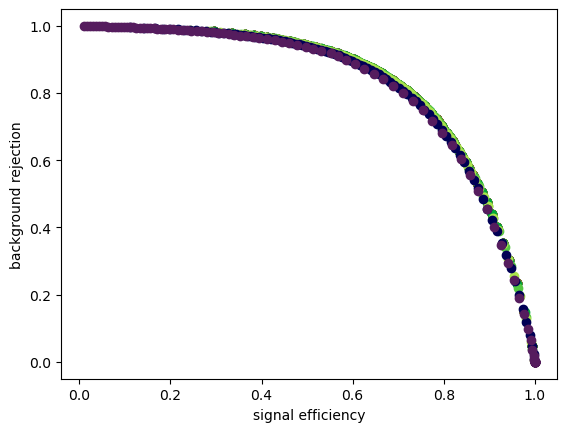

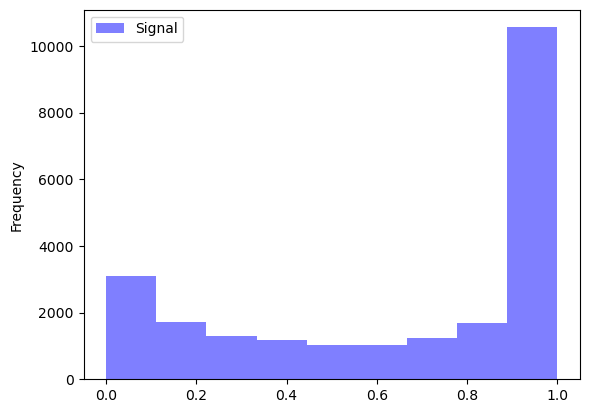

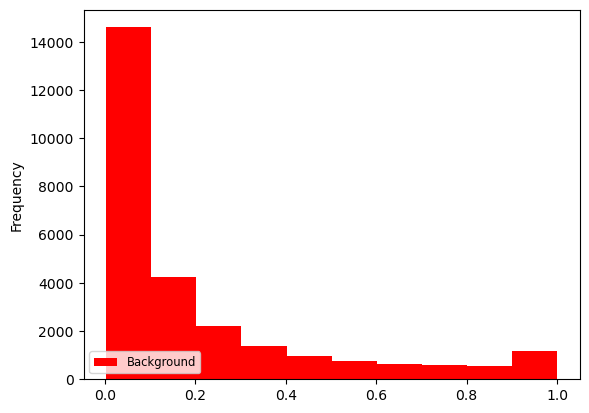

In [2]:
import sys, os
import pandas as pd
import numpy as np
import warnings
import tensorflow.compat.v1 as tf

seed=12
np.random.seed(seed)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.set_random_seed(seed)
filename=os.path.expanduser('~')+'\Homework Computing physics\Data\SUSY.csv' 

columns=["signal", "lepton 1 pT", "lepton 1 eta", "lepton 1 phi", "lepton 2 pT", "lepton 2 eta", 
         "lepton 2 phi", "missing energy magnitude", "missing energy phi", "MET_rel", 
         "axial MET", "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos(theta_r1)"]

df_train=pd.read_csv(filename,names=columns,nrows=1500000,engine='python')
df_test=pd.read_csv(filename,names=columns,nrows=50000, skiprows=1500000,engine='python')

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
def getTrainData(nVar):
    designMatrix = df_train.iloc[:,1:nVar+1].values
    labels = df_train['signal'].values 
    return (designMatrix,labels)

def getTestData(nVar):
    designMatrix = df_test.iloc[:,1:nVar+1].values
    labels = df_test['signal'].values
    return (designMatrix,labels)

def build_roc_curve(probs, signal_bit, threshes):
    signal_probs = pd.Series(probs[:,1])
    signal_true = pd.Series(signal_bit)
    signal_df = pd.DataFrame(signal_probs, columns=['sig_prob'])
    signal_df.loc[:,'sig_true'] = signal_true
    Acceptance = []
    Rejection = []
    for thresh in threshes:
        signal_df.loc[:,'accept'] = signal_df['sig_prob'] > thresh
        nSigCor = len(signal_df[(signal_df['accept']) & (signal_df['sig_true']==1.)])
        nSig = len(signal_df[signal_df['sig_true']==1.])
        nBkgCor = len(signal_df[ (signal_df['sig_true']==0.) & (~signal_df['accept'])])
        nBkg = len(signal_df[signal_df['sig_true']==0.])
        Acceptance.append(nSigCor/nSig) # False positive rate
        Rejection.append(nBkgCor/nBkg) # True positive rate

    return Acceptance, Rejection
    
def runTensorFlowRegression(nVar,alpha):
    tf.compat.v1.disable_eager_execution()
    x = tf.placeholder(tf.float32,[None,nVar])
    W = tf.Variable(tf.zeros([nVar,2])) 
    b = tf.Variable(tf.zeros([2]))
    y = tf.nn.softmax(tf.matmul(x, W) + b)
    y_ = tf.placeholder(tf.float32, [None, 2])
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y,labels=y_)+alpha*tf.nn.l2_loss(W))
    train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    Var_train, Sig_train_bit1 = getTrainData(nVar)
    Sig_train_bit0 = Sig_train_bit1.copy()
    Sig_train_bit0 = 1 - Sig_train_bit0
    Sig_train = np.column_stack((Sig_train_bit0,Sig_train_bit1))
    n_data = len(Sig_train_bit1)
    minibatch_size = 1000
    n_minibatch = n_data//minibatch_size
    print('\t Training with %i minibatches, dataset size is %i'%(n_minibatch,n_data))
    for i in range(0, n_minibatch):
        sys.stdout.write("%.3f %% completed \r"%(100*i/n_minibatch))
        sys.stdout.flush()
        start = i*minibatch_size
        end = (i+1)*minibatch_size-1
        
        batch_x = Var_train[start:end]
        batch_y = Sig_train[start:end]
        sess.run(train_step, feed_dict={x: batch_x, y_: batch_y})

    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    Var_test = df_test.iloc[:,1:nVar+1].values
    
    Sig_test_bit1 = df_test['signal'].values
    
    Sig_test_bit0 = Sig_test_bit1.copy()
    Sig_test_bit0 = 1 - Sig_test_bit0
    Sig_test = np.column_stack((Sig_test_bit0,Sig_test_bit1))
    print("\t Accuracy for alpha %.1E : %.3f" %(alpha,sess.run(accuracy, feed_dict={x: Var_test, y_: Sig_test})))
    
    weights = W.eval(session=sess)
    probs = y.eval(feed_dict = {x: Var_test}, session = sess)
    print('\t Computing ROC curve ...')
    threshes = np.arange(0,1,0.01)
    Acceptance, Rejection = build_roc_curve(probs, Sig_test_bit1, threshes)

    return (probs,Acceptance,Rejection)

alphas = np.logspace(-10,-1,11)
fig = plt.figure()
ax = fig.add_subplot(111)
it=0


for alpha in alphas:
    print("Training for alpha = %.2E"%alpha)
    c1 = 1.*( float(it) % 3.)/3.0
    c2 = 1.*( float(it) % 9.)/9.0
    c3 = 1.*( float(it) % 27.)/27.0
    probsSimple,accep,rej = runTensorFlowRegression(8,alpha)
    ax.scatter(accep,rej,c=[[c1,c2,c3]],label='Alpha: %.1E' %alpha)
    it+=1

probsSimple,accep,rej = runTensorFlowRegression(8,.00001)
Signal = df_test['signal'].values

df_test_acc = pd.DataFrame({'PROB':probsSimple[:,1]})
df_test_acc['SIG']=Signal
df_test_acc_sig = df_test_acc.query('SIG==1')
df_test_acc_bkg = df_test_acc.query('SIG==0')
df_test_acc_sig.plot(kind='hist',y='PROB',color='blue',alpha=0.5,bins=np.linspace(0,1,10),label='Signal')
df_test_acc_bkg.plot(kind='hist',y='PROB',color='red',label='Background')

ax.set_xlabel('signal efficiency')
ax.set_ylabel('background rejection')
plt.legend(loc='lower left', fontsize = 'small');
plt.show()

	 Training with 1500 minibatches, dataset size is 1500000
	 Accuracy for alpha 1.0E-10 : 0.788
	 Computing ROC curve ...
	 Training with 1500 minibatches, dataset size is 1500000
	 Accuracy for alpha 1.3E-09 : 0.788
	 Computing ROC curve ...
	 Training with 1500 minibatches, dataset size is 1500000
	 Accuracy for alpha 1.6E-08 : 0.788
	 Computing ROC curve ...
	 Training with 1500 minibatches, dataset size is 1500000
	 Accuracy for alpha 2.0E-07 : 0.788
	 Computing ROC curve ...
	 Training with 1500 minibatches, dataset size is 1500000
	 Accuracy for alpha 2.5E-06 : 0.788
	 Computing ROC curve ...
	 Training with 1500 minibatches, dataset size is 1500000
	 Accuracy for alpha 3.2E-05 : 0.788
	 Computing ROC curve ...
	 Training with 1500 minibatches, dataset size is 1500000
	 Accuracy for alpha 4.0E-04 : 0.787
	 Computing ROC curve ...
	 Training with 1500 minibatches, dataset size is 1500000
	 Accuracy for alpha 5.0E-03 : 0.778
	 Computing ROC curve ...
	 Training with 1500 minibatches

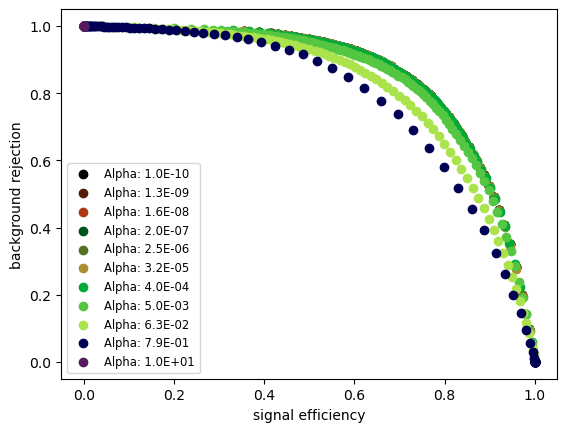

In [3]:
alphas = np.logspace(-10,1,11)
fig = plt.figure()
ax = fig.add_subplot(111)
it=0
for alpha in alphas:
    c1 = 1.*( float(it) % 3.)/3.0
    c2 = 1.*( float(it) % 9.)/9.0
    c3 = 1.*( float(it) % 27.)/27.0
    probsSimple,accep,rej = runTensorFlowRegression(18,alpha)
    ax.scatter(accep,rej,c=[[c1,c2,c3]],label='Alpha: %.1E' %alpha)
    it+=1
    
ax.set_xlabel('signal efficiency')
ax.set_ylabel('background rejection')
plt.legend(loc='lower left', fontsize = 'small');
plt.show()

### 下面的代码需要清空内核后执行，否则会报错

InvalidParameterError: The 'loss' parameter of SGDClassifier must be a str among {'squared_hinge', 'modified_huber', 'hinge', 'squared_error', 'huber', 'perceptron', 'squared_epsilon_insensitive', 'epsilon_insensitive', 'log_loss'}. Got 'log' instead.

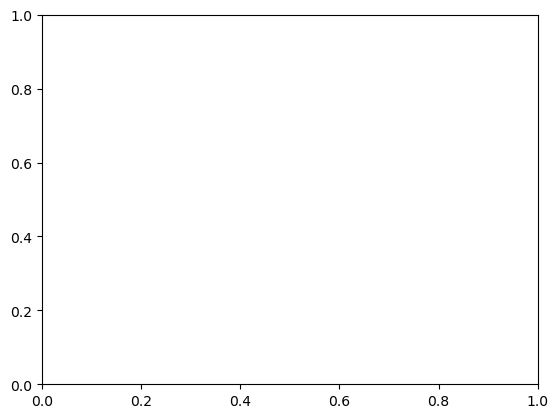

In [4]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier

def runSciKitRegressionL2(nVar, alpha):
    X_train, y_train = getTrainData(nVar)
    X_test, y_test = getTestData(nVar)
    clf = SGDClassifier(loss="log", penalty="l2",alpha=alpha,max_iter=5,tol=None)
    clf.fit(X_train,y_train.ravel())
    predictions = clf.predict(X_test)
    print('Accuracy on test data with alpha %.2E : %.3f' %(alpha,clf.score(X_test,y_test)) )
    probs = clf.predict_proba(X_test)
    thresholds = np.arange(0,1,.01)
    Acceptance, Rejection = build_roc_curve(probs, y_test, thresholds)
    return (probs, Acceptance, Rejection)


def runSciKitRegressionL1(nVar,alpha):
    X_train, y_train = getTrainData(nVar)
    X_test, y_test = getTestData(nVar)
    clf = SGDClassifier(loss="log", penalty="l1",alpha=alpha,max_iter=5,tol=None)
    clf.fit(X_train,y_train.ravel())
    predictions = clf.predict(X_test)
    print('Accuracy on test data with alpha %.2E : %.3f' %(alpha,clf.score(X_test,y_test)) )
    probs = clf.predict_proba(X_test)
    thresholds = np.arange(0,1,.01)
    Acceptance, Rejection = build_roc_curve(probs, y_test, thresholds)
    return (probs,Acceptance,Rejection)
alphas = np.logspace(-10,1,11)
fig = plt.figure()
ax = fig.add_subplot(111)
it=0
for alpha in alphas:
    c1 = 1.*( float(it) % 3.)/3.0
    c2 = 1.*( float(it) % 9.)/9.0
    c3 = 1.*( float(it) % 27.)/27.0
    probs,accept,rej = runSciKitRegressionL1(8,alpha)
    ax.scatter(accept,rej,c=[[c1,c2,c3]],label='Alpha: %.1E' %alpha)
    it+=1

ax.set_xlabel('signal efficiency')
ax.set_ylabel('background rejection')
plt.legend(loc='lower left', fontsize = 'small');
plt.show()

In [5]:
probsSimple,accep,rej = runSciKitRegressionL1(8,.5)
Signal = df_test.iloc[:,0:1]

df_test_acc = pd.DataFrame({'PROB':probsSimple[:,1]})
df_test_acc['SIG']=Signal
df_test_acc_sig = df_test_acc.query('SIG==1')
df_test_acc_bkg = df_test_acc.query('SIG==0')
df_test_acc_sig.plot(kind='hist',y='PROB',color='blue',alpha=0.5,bins=np.linspace(0,1,10),label='Signal')
df_test_acc_bkg.plot(kind='hist',y='PROB',color='red',label='Background')

InvalidParameterError: The 'loss' parameter of SGDClassifier must be a str among {'squared_hinge', 'modified_huber', 'hinge', 'squared_error', 'huber', 'perceptron', 'squared_epsilon_insensitive', 'epsilon_insensitive', 'log_loss'}. Got 'log' instead.

InvalidParameterError: The 'loss' parameter of SGDClassifier must be a str among {'squared_hinge', 'modified_huber', 'hinge', 'squared_error', 'huber', 'perceptron', 'squared_epsilon_insensitive', 'epsilon_insensitive', 'log_loss'}. Got 'log' instead.

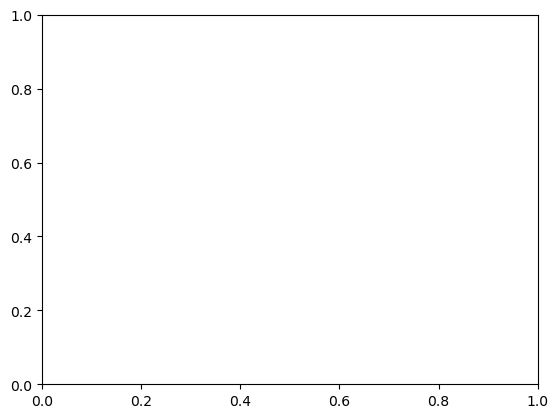

In [6]:
alphas = np.logspace(-10,1,11)
fig = plt.figure()
ax = fig.add_subplot(111)
it=0
for alpha in alphas:
    c1 = 1.*( float(it) % 3.)/3.0
    c2 = 1.*( float(it) % 9.)/9.0
    c3 = 1.*( float(it) % 27.)/27.0
    probs,accept,rej = runSciKitRegressionL1(18,alpha)
    ax.scatter(accept,rej,c=[[c1,c2,c3]],label='Alpha: %.1E' %alpha)
    it+=1

ax.set_xlabel('signal efficiency')
ax.set_ylabel('background rejection')
plt.legend(loc='lower left', fontsize = 'small');
plt.show()

In [ ]:
alphas = np.logspace(-10,1,11)
fig = plt.figure()
ax = fig.add_subplot(111)
it=0
for alpha in alphas:
    c1 = 1.*( float(it) % 3.)/3.0
    c2 = 1.*( float(it) % 9.)/9.0
    c3 = 1.*( float(it) % 27.)/27.0
    probs,accept,rej = runSciKitRegressionL2(8,alpha)
    ax.scatter(accept,rej,c=[[c1,c2,c3]],label='Alpha: %.1E' %alpha)
    it+=1

ax.set_xlabel('signal efficiency')
ax.set_ylabel('background rejection')
plt.legend(loc='lower left', fontsize = 'small');
plt.show()

In [ ]:
alphas = np.logspace(-10,1,11)
fig = plt.figure()
ax = fig.add_subplot(111)
it=0
for alpha in alphas:
    c1 = 1.*( float(it) % 3.)/3.0
    c2 = 1.*( float(it) % 9.)/9.0
    c3 = 1.*( float(it) % 27.)/27.0
    probs,accept,rej = runSciKitRegressionL2(18,alpha)
    ax.scatter(accept,rej,c=[[c1,c2,c3]],label='Alpha: %.1E' %alpha)
    it+=1

ax.set_xlabel('signal efficiency')
ax.set_ylabel('background rejection')
plt.legend(loc='lower left', fontsize = 'small');
plt.show()